In [22]:
import numpy as np
import pandas as pd

from datasets import load_dataset,Dataset,DatasetDict
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Note: You can use any model in this example (not necessarily a model trained for classification) since we will only use that model’s body and leave the head.

In [29]:
dataset_v2_path = "../inputs/IMDB-Dataset.csv"

## Load Dataset with HF's load_dataset

In [31]:
dataset_hf=load_dataset("csv", data_files=dataset_v2_path)

#show preview of dataset
print(dataset_hf)
#type of dataset_hf
type(dataset_hf)

Generating train split: 50000 examples [00:01, 31256.66 examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 50000
    })
})


datasets.dataset_dict.DatasetDict

In [32]:
dataset_hf.set_format('pandas')
print(type(dataset_hf))

dataset_hf=dataset_hf['train'][:]


<class 'datasets.dataset_dict.DatasetDict'>
<class 'pandas.core.frame.DataFrame'>


In [33]:
# dataset_hf.drop_duplicates(subset=['headline'],inplace=True)

dataset_hf['sentiment'] = dataset_hf['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
dataset_hf.rename(columns={'sentiment':'label'},inplace=True)

print(dataset_hf)
dataset_hf=dataset_hf.reset_index()[['review','label']]

dataset_hf=Dataset.from_pandas(dataset_hf)


# Train Test Valid Split
train_testvalid = dataset_hf.train_test_split(test_size=0.2,seed=15)


test_valid = train_testvalid['test'].train_test_split(test_size=0.5,seed=15)

dataset_hf = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

dataset_hf


                                                  review  label
0      One of the other reviewers has mentioned that ...      1
1      A wonderful little production. <br /><br />The...      1
2      I thought this was a wonderful way to spend ti...      1
3      Basically there's a family where a little boy ...      0
4      Petter Mattei's "Love in the Time of Money" is...      1
...                                                  ...    ...
49995  I thought this movie did a down right good job...      1
49996  Bad plot, bad dialogue, bad acting, idiotic di...      0
49997  I am a Catholic taught in parochial elementary...      0
49998  I'm going to have to disagree with the previou...      0
49999  No one expects the Star Trek movies to be high...      0

[50000 rows x 2 columns]


DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 5000
    })
    valid: Dataset({
        features: ['review', 'label'],
        num_rows: 5000
    })
})

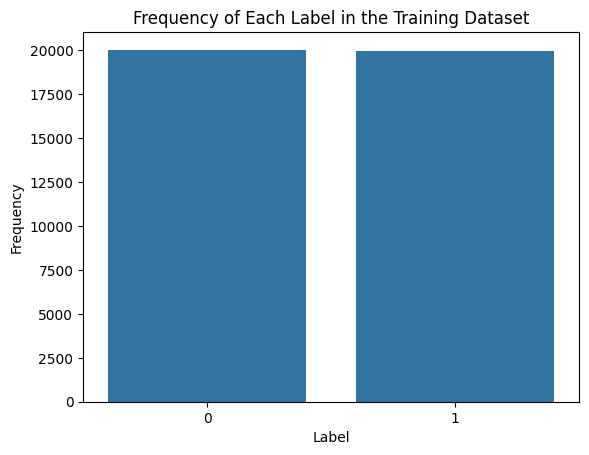

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Create a bar plot to show the distribution of the labels
sns.countplot(x=dataset_hf['train']['label'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of Each Label in the Training Dataset')
plt.show()

In [40]:
"""
other visualizations of the dataset
"""

#check random samples of the dataset to understand how it was compiled

# Display 10 random samples from the training dataset
print(dataset_hf['train'].shuffle(seed=42).select(range(10)).to_pandas())


                                              review  label
0  I liked all the Lilo and Stitch movies. The TV...      0
1  Gregory Peck gives a brilliant performance in ...      1
2  The essence of this film falls on judgments by...      1
3  This movie was Hilarious! It occasionally went...      1
4  I have always been interested in anything abou...      0
5  I believe anyone who enjoyed Eisentein's Ivan ...      1
6  I love this movie, but the music at all the al...      1
7  This "clever" film was originally a Japanese f...      0
8  This was just another marvelous film of the Be...      1
9  I heard that after the first Oceans movie, the...      1


In [7]:
# Define the checkpoint for the pre-trained model
checkpoint = "distilbert-base-uncased"

# Load the tokenizer for the specified checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint, clean_up_tokenization_spaces=True)

# Set the maximum length for the tokenizer to 512 tokens
tokenizer.model_max_len = 512

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Vector size "distilbert-base-uncased"

In the model distilbert-base-uncased, each token is embedded into a vector of size 768. The shape of the output from the base model is 

### (batch_size, max_sequence_length, embedding_vector_size=768)

In [8]:
# Define a function to tokenize the dataset
def tokenize(batch):
  return tokenizer(batch["review"], truncation=True,  padding="max_length"  ,max_length=512)

tokenized_dataset = dataset_hf.map(tokenize, batched=True)
tokenized_dataset

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'label', 'input_ids', 'attention_mask'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
    valid: Dataset({
        features: ['review', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
})

In [9]:
tokenized_dataset.set_format('torch', columns=["input_ids", "attention_mask", "label"] )
#display the tokenized dataset
print(tokenized_dataset)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



DatasetDict({
    train: Dataset({
        features: ['review', 'label', 'input_ids', 'attention_mask'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
    valid: Dataset({
        features: ['review', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
})


In [10]:
#display some samples of the tokenized dataset
print(tokenized_dataset['train'][:5])

{'label': tensor([0, 0, 0, 0, 1]), 'input_ids': tensor([[  101,  2054,  1996,  ...,     0,     0,     0],
        [  101,  1045,  2572,  ...,     0,     0,     0],
        [  101,  1996,  2919,  ...,     0,     0,     0],
        [  101,  2023,  3185,  ...,     0,     0,     0],
        [  101, 11268,  1012,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


## We construct `MyTaskSpecificCustomModel` class that inherits from the nn.Module.

In [11]:
class MyTaskSpecificCustomModel(nn.Module):
    """
    A task-specific custom transformer model. This model loads a pre-trained transformer model and adds a new dropout 
    and linear layer at the end for fine-tuning and prediction on specific tasks.
    """
    def __init__(self, checkpoint, num_labels ):
        """
        Args:
            checkpoint (str): The name of the pre-trained model or path to the model weights.
            num_labels (int): The number of output labels in the final classification layer.
        """
        super(MyTaskSpecificCustomModel, self).__init__()
        self.num_labels = num_labels
        
        self.model = model = AutoModel.from_pretrained(checkpoint, config = AutoConfig.from_pretrained(checkpoint, 
                                                                                                       output_attention = True, 
                                                                                                       output_hidden_state = True ) )
        # New Layer
        self.dropouts = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels )
        
    def forward(self, input_ids = None, attention_mask=None, labels = None ):
        """
        Forward pass for the model.
        
        Args:
            input_ids (torch.Tensor, optional): Tensor of input IDs. Defaults to None.
            attention_mask (torch.Tensor, optional): Tensor for attention masks. Defaults to None.
            labels (torch.Tensor, optional): Tensor for labels. Defaults to None.
            
        Returns:
            TokenClassifierOutput: A named tuple with the following fields:
            - loss (torch.FloatTensor of shape (1,), optional, returned when label_ids is provided) – Classification loss.
            - logits (torch.FloatTensor of shape (batch_size, num_labels)) – Classification scores before SoftMax.
            - hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) – Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).
            - attentions (tuple(torch.FloatTensor), optional, returned when output_attentions=True is passed or when config.output_attentions=True) – Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).
        """
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask  )
        
        last_hidden_state = outputs[0]
        
        sequence_outputs = self.dropouts(last_hidden_state)
        
        logits = self.classifier(sequence_outputs[:, 0, : ].view(-1, 768 ))
        
        loss = None
        loss = None
        if labels is not None:
            loss_func = nn.CrossEntropyLoss()
            loss = loss_func(logits.view(-1, self.num_labels), labels.view(-1))
            
            return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

# Create PyTorch DataLoader

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_dataset['train'], shuffle = True, batch_size = 32, collate_fn = data_collator
)

eval_dataloader = DataLoader(
    tokenized_dataset['valid'], shuffle = True, collate_fn = data_collator
)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_task_specific = MyTaskSpecificCustomModel(checkpoint=checkpoint, num_labels=2 ).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [14]:
import torch.optim as optim
from transformers import get_scheduler

optimizer = optim.AdamW(model_task_specific.parameters(), lr=5e-5)

num_epoch = 3

num_training_steps = num_epoch * len(train_dataloader)

lr_scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [16]:
import evaluate
metric = evaluate.load("f1")

# Training

In [17]:
from tqdm.auto import tqdm

progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epoch * len(eval_dataloader) ))


for epoch in range(num_epoch):
    model_task_specific.train()
    for batch in train_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model_task_specific(**batch)
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar_train.update(1)
        
    model_task_specific.eval()
    for batch in eval_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        with torch.no_grad():
            outputs = model_task_specific(**batch)
            
        logits = outputs.logits
        predictions = torch.argmax(logits, dim = -1 )
        metric.add_batch(predictions = predictions, references = batch['labels'] )
        progress_bar_eval.update(1)
        
    print(metric.compute()) 

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

{'f1': 0.9231083844580777}
{'f1': 0.9346237408650997}
{'f1': 0.9331197436924309}


AttributeError: 'MyTaskSpecificCustomModel' object has no attribute 'save_pretrained'

## Saving the Model


In [29]:
from transformers import AutoModel, AutoConfig, AutoTokenizer
from transformers.modeling_outputs import TokenClassifierOutput

def save_model_and_tokenizer(model, save_directory):
    """
    Save the model, tokenizer, and configuration
    """
    # Create directory if it doesn't exist
    import os
    os.makedirs(save_directory, exist_ok=True)
    
    # Save model state dict
    model_path = os.path.join(save_directory, "model_state.pt")
    model_config = {
        'checkpoint': "distilbert-base-uncased",
        'num_labels': model.num_labels,
        'state_dict': model.state_dict()
    }
    torch.save(model_config, model_path)
    
    # Save tokenizer and config
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", clean_up_tokenization_spaces = True)
    config = AutoConfig.from_pretrained("distilbert-base-uncased", output_attention=True, output_hidden_state=True)
    
    tokenizer.save_pretrained(save_directory)
    config.save_pretrained(save_directory)
    
    # Save requirements
    requirements = [
        "torch>=1.9.0",
        "transformers>=4.15.0",
        "numpy>=1.19.5"
    ]
    
    with open(os.path.join(save_directory, "requirements.txt"), "w") as f:
        f.write("\n".join(requirements))
    
    print(f"Model and requirements saved to {save_directory}")
    


save_model_and_tokenizer(model_task_specific, "saved_model_directory")

Model and requirements saved to saved_model_directory


## Post Training Evaluation

In [28]:
model_task_specific.eval()

test_dataloader = DataLoader(
    tokenized_dataset['test'], batch_size = 32, collate_fn = data_collator
)

for batch in test_dataloader:
    batch = { k: v.to(device) for k, v in batch.items() }
    with torch.no_grad():
        outputs = model_task_specific(**batch)
        
    logits = outputs.logits
    predictions = torch.argmax(logits, dim = -1)
    metric.add_batch(predictions = predictions, references=batch['labels'] )
metric.compute()  

{'f1': 0.9430990352431581}